# Wykrywanie anomalii sieciowy

## 4 Autoeknodery (ae)

- Autoeknoder
- PCA

## Plan

- Wprowadzenie 15 min
- Autoeknoder 40 min
- PCA 25 min
- Podsumowanie 10 min


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import jax
import jax.numpy as jnp
from jax.example_libraries.optimizers import adam
from jax.example_libraries import stax

# Diamenty

Dalej pracujemy na danych o diamentach, ale bez etykiet

In [2]:
diamonds = pd.read_csv('../data/diamonds.csv')
diamonds = diamonds.sample(frac=1)
diamonds.head()

x_raw = diamonds[['carat','x','y','z']]


c:\Users\Krzysztof_Gora\AppData\Local\miniconda3\envs\anomalie\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Krzysztof_Gora\AppData\Local\miniconda3\envs\anomalie\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Krzysztof_Gora\AppData\Local\miniconda3\envs\anomalie\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Krzysztof_Gora\AppData\Local\miniconda3\envs\anomalie\lib\site-packages\seaborn

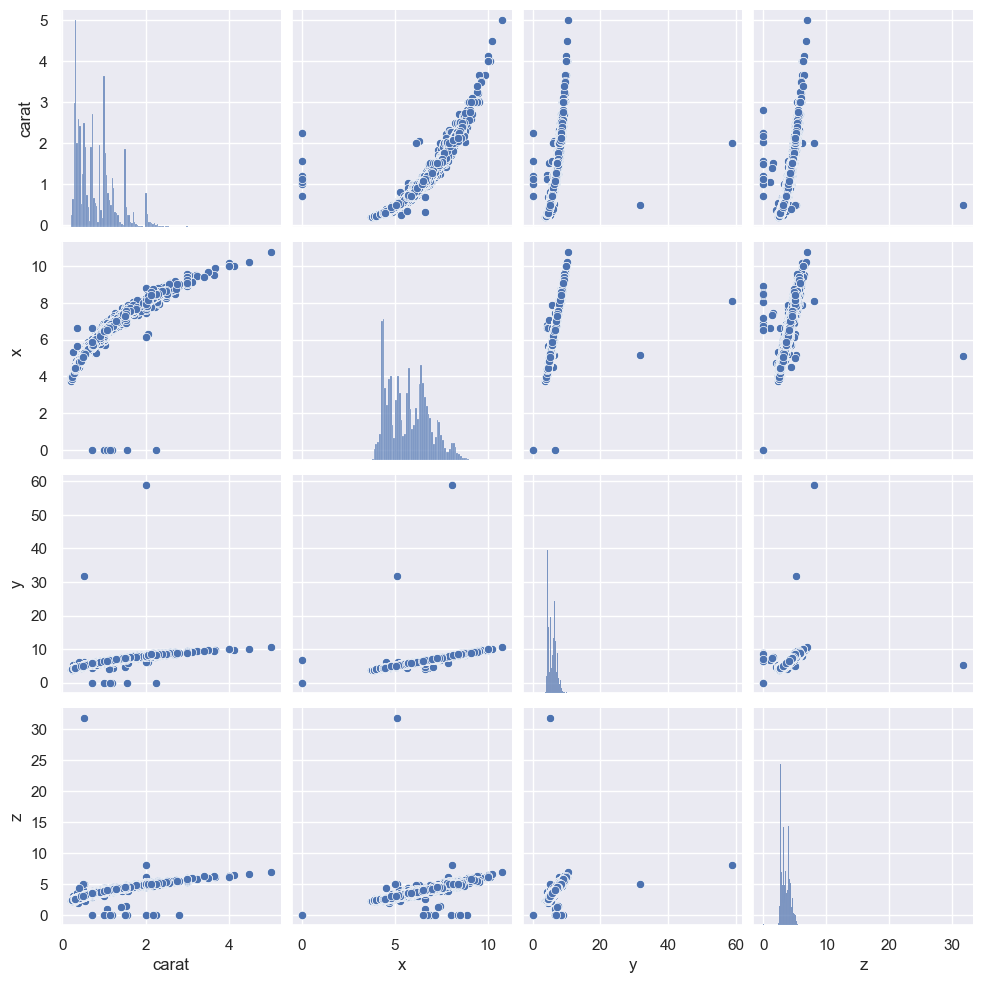

In [3]:
sns.pairplot(x_raw)

In [4]:
x=x_raw.to_numpy()
m = np.mean(x, 0)
s = np.std(x, 0)
x = (x-m)/s

# μ lib

In [5]:
def vector_mse(y,yhat):
    return jnp.mean(jnp.square(y-yhat), axis=-1)

# Autoenkoder

Autoenkoder to siec neuronowa prezybliżająca funkcję $f(x)=x$

## Zadanie

Zbudować i wytrenować autoenkoder kompresujący `x,x,z,carat` do jednej liczby.

In [11]:
batch_size=128
steps=20000
learning_rate=0.001
train_split=int(0.7*x.shape[0])

k = jax.random.PRNGKey(42)

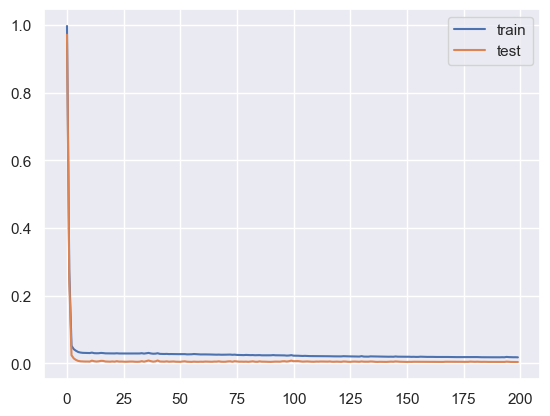

In [14]:
#TODO

encoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(1)
)

decoder = stax.serial(
    stax.Dense(16),
    stax.Relu,
    stax.Dense(4)
)

nn = stax.serial(encoder, decoder)

init_nn, apply_nn = nn
opt_init, opt_update, get_params = adam(learning_rate)

@jax.jit
def step(i, opt_state, x, y):
  params = get_params(opt_state)

  def loss(params,x,y):
    reconstruction = apply_nn(params, x)
    return jnp.mean(vector_mse(y, reconstruction))

  g = jax.grad(loss)(params, x,y)
  opt_state = opt_update(i, g, opt_state)
  step_loss = loss(get_params(opt_state),x,y)
  return opt_state, step_loss

@jax.jit
def test_loss(opt_state, x, y):
    params = get_params(opt_state)
    reconstruction = apply_nn(params, x)
    return jnp.mean(vector_mse(y, reconstruction))

_, params  = init_nn(k,(batch_size,x.shape[1]))
opt_state = opt_init(params)

losses=[]
test_losses=[]
train_steps=[]


for i in range(steps):
    idx = np.random.randint(0, train_split,size=batch_size)
    bx = x[idx,...]

    opt_state, step_loss = step(i, opt_state, bx, bx)

    if i % 100 == 0:
        tx=x[train_split:, ...]
        test_losses.append(test_loss(opt_state, tx, tx))
        train_steps.append(i)
        losses.append(test_loss(opt_state,x[:train_split],x[:train_split]))

plt.plot(losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()

## ZAdanie

Narysować wykres rozrzutu rekonstrukcji danych.

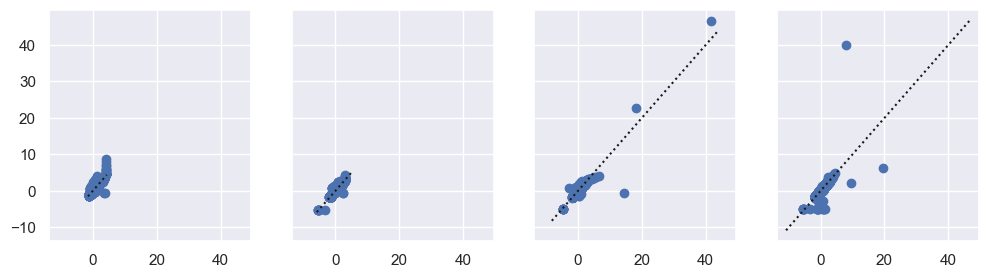

In [17]:
#TODO
rekonstrucja = jax.jit(apply_nn)(get_params(opt_state), x[:train_split])
fig, axs = plt.subplots(ncols=4, sharey=True, sharex=True, figsize=(12, 3))

for i, ax in enumerate(axs):
    ax.scatter(rekonstrucja[:, i], x[:train_split, i])
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k:')


## Zadanie

Narysować histogram ukrytej reprezentacji

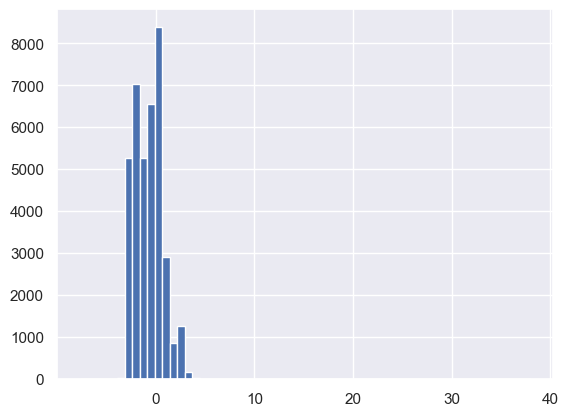

In [23]:
#TODO
encoder_params, decoder_params = get_params(opt_state)
z = encoder[1](encoder_params, x[:train_split, ...])
plt.hist(np.asarray(z), 60);

## Zadanie

1. Narysować histogram błędu rekonstrukcji na biorze testowym
2. Wprowadzić anomalie i ją wykryć

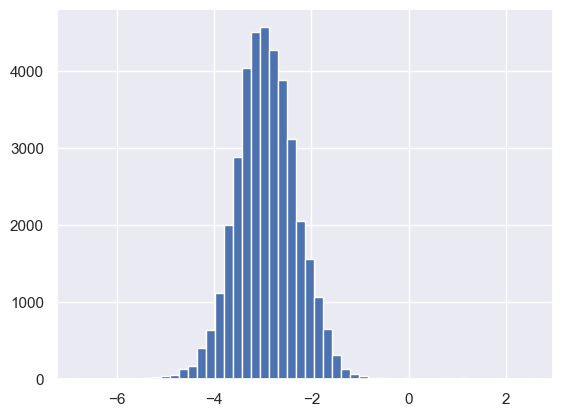

In [26]:
#TODO
@jax.jit
def reconstruction_error(opt_state, x):
    params = get_params(opt_state)
    reconstruction = apply_nn(params, x)
    return vector_mse(x, reconstruction)

errors = reconstruction_error(opt_state, x[:train_split, ...])
plt.hist(np.log10(errors), 50);


In [27]:
xtmp = x[:train_split, ...]
xtmp[100, 2] = 40 * xtmp[100, 2]
errors = reconstruction_error(opt_state, xtmp)

q = np.quantile(errors, 0.99)
anomalie, = np.where(errors>0)
print(len(anomalie), q)
assert 100 in anomalie

37758 0.03449895083904267


# PCA

PCA to liniowy autoenkoder, dla którego wiemy, że macierz transformacji jest utworzona z wektorów własnych macierzy kowariancji.

In [ ]:
x = diamonds[['x','y','z']].to_numpy()
m = np.mean(x, 0)
s = np.std(x, 0)
x = (x-m)/s

## Zadanie

Wykonać PCA na danych `x,y,z`

In [30]:
cov_mat = np.cov(x.T)
eig_val, eig_vec = np.linalg.eig(cov_mat)
idx_sort = np.flip(eig_val.argsort())
components = eig_vec[:, idx_sort]
variances = eig_val[idx_sort]

assert np.allclose(components@components.T, np.eye(4),rtol=1e-3,atol=1e-4)

In [31]:
z = x@components
np.var(z,0)
assert np.allclose(np.var(z,0), variances,rtol=1e-3,atol=1e-4)

<Axes: xlabel='0', ylabel='1'>

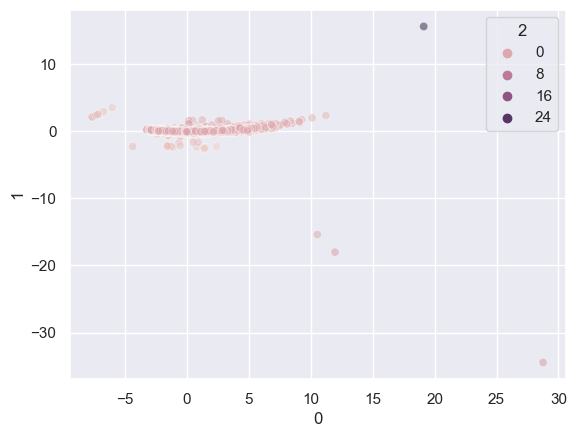

In [32]:
sns.scatterplot(
    data= pd.DataFrame(z),
    x=0,
    y=1,
    hue=2,
    alpha=0.5
)

## Szybsza i stabilniejsza wersja PCA
https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

In [33]:
u,s,vh=np.linalg.svd(x,full_matrices=False)
fi = vh.T
z = u@np.diag(s)